# TMDB Movie Analysis - Complete Pipeline

This notebook runs the entire analysis workflow sequentially:

## Pipeline Stages
1. **API Data Fetching** - Fetch movie data from TMDB API
2. **Data Cleaning** - Clean and preprocess raw data
3. **KPI Analysis** - Calculate performance metrics
4. **Visualization** - Create visual insights

## Setup

In [1]:
# Standard library
import sys
import os
from pathlib import Path
import json
import yaml
import ast

# Data processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Add project root to path and set working directory
project_root = Path.cwd().parent
sys.path.append(str(project_root))
os.chdir(str(project_root))

# Project modules
from src.fetch.fetch_tmdb_api import TMDBFetcher
from src.analytics.kpi_calculator import *
from src.analytics.filters import *
from src.analytics.aggregators import *
from src.viz.plots import *
from src.utils.helpers import load_config, setup_logging

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Setup logger
logger = setup_logging(module_name='pipeline_notebook')
logger.info("=" * 60)
logger.info("✓ Pipeline initialized")

2025-12-15 14:58:16 - pipeline_notebook - INFO - ============================================================
2025-12-15 14:58:16 - pipeline_notebook - INFO - ✓ Pipeline initialized


In [2]:
# Load configuration
config = load_config('config/config.yaml')
logger.info("✓ Configuration loaded")

2025-12-15 14:58:16 - pipeline_notebook - INFO - ✓ Configuration loaded


---

# **SECTION 1: API DATA FETCHING**

Fetch movie data from TMDB API and save as JSON files.

---

In [3]:
# Load configuration
# config = load_config('config/config.yaml')

logger.info("Configuration loaded successfully")
logger.info(f"  API Base URL: {config['api']['base_url']}")
logger.info(f"  Rate Limit: {config['api']['rate_limit_delay']}s")
logger.info(f"  Raw Data Path: {config['paths']['raw_data']}")

2025-12-15 14:58:16 - pipeline_notebook - INFO - Configuration loaded successfully
2025-12-15 14:58:16 - pipeline_notebook - INFO -   API Base URL: https://api.themoviedb.org/3
2025-12-15 14:58:16 - pipeline_notebook - INFO -   Rate Limit: 0.25s
2025-12-15 14:58:16 - pipeline_notebook - INFO -   Raw Data Path: data/raw/


## 2. Define Movie IDs to Fetch

Specify the TMDB movie IDs you want to extract data for. These IDs can be found on themoviedb.org.

In [4]:
# Example: Marvel Cinematic Universe movies
movie_ids = [0,299534,19995,140607,299536,597,135397,420818,24428,168259,99861,284054,12445,181808,330457,351286,109445,321612,260513]


## 3. Initialize Fetcher and Extract Data

The TMDBFetcher will:
- Connect to TMDB API using credentials from `.env` file
- Fetch movie details including credits and keywords
- Save each movie as a separate JSON file in `data/raw/`
- Apply rate limiting to respect API limits

In [5]:
# Initialize the fetcher (using config from pipeline setup)
fetcher = TMDBFetcher()

logger.info("="*60)
logger.info("Starting data extraction...")
logger.info("="*60)

# Fetch movies (skip_existing=True means already downloaded files won't be re-fetched)
fetched_count = fetcher.fetch_movies(movie_ids, skip_existing=True)

logger.info("="*60)
logger.info(f"✓ Successfully fetched {fetched_count} new movies")
logger.info(f"✓ Data saved to: {fetcher.raw_data_path}")
logger.info("="*60)

2025-12-15 14:58:16 - pipeline_notebook - INFO - ============================================================
2025-12-15 14:58:16 - pipeline_notebook - INFO - Starting data extraction...
2025-12-15 14:58:16 - pipeline_notebook - INFO - ============================================================


Fetching movies:   0%|          | 0/19 [00:00<?, ?it/s]

2025-12-15 14:58:17 - fetch - ERROR - Error fetching movie 0: 404 Client Error: Not Found for url: https://api.themoviedb.org/3/movie/0?api_key=b52da0c30e5cff65bed4b8dbda2060d5&append_to_response=credits%2Ckeywords


Fetching movies: 100%|██████████| 19/19 [00:19<00:00,  1.03s/it]

2025-12-15 14:58:36 - pipeline_notebook - INFO - ============================================================
2025-12-15 14:58:36 - pipeline_notebook - INFO - ✓ Successfully fetched 18 new movies
2025-12-15 14:58:36 - pipeline_notebook - INFO - ✓ Data saved to: data\raw
2025-12-15 14:58:36 - pipeline_notebook - INFO - ============================================================


## 4. Verify Extracted Data

Check that the JSON files were created and examine a sample.

In [6]:
# List all JSON files in raw data directory
import json

raw_data_path = Path(config['paths']['raw_data'])
json_files = list(raw_data_path.glob("*.json"))

logger.info(f"Total JSON files in {raw_data_path}: {len(json_files)}")
logger.info("\nFiles:")
for file in sorted(json_files)[:10]:  # Show first 10
    logger.info(f"  - {file.name}")

2025-12-15 14:58:36 - pipeline_notebook - INFO - Total JSON files in data\raw: 18
2025-12-15 14:58:36 - pipeline_notebook - INFO - 
Files:
2025-12-15 14:58:36 - pipeline_notebook - INFO -   - 109445.json
2025-12-15 14:58:36 - pipeline_notebook - INFO -   - 12445.json
2025-12-15 14:58:36 - pipeline_notebook - INFO -   - 135397.json
2025-12-15 14:58:36 - pipeline_notebook - INFO -   - 140607.json
2025-12-15 14:58:36 - pipeline_notebook - INFO -   - 168259.json
2025-12-15 14:58:36 - pipeline_notebook - INFO -   - 181808.json
2025-12-15 14:58:36 - pipeline_notebook - INFO -   - 19995.json
2025-12-15 14:58:36 - pipeline_notebook - INFO -   - 24428.json
2025-12-15 14:58:36 - pipeline_notebook - INFO -   - 260513.json
2025-12-15 14:58:36 - pipeline_notebook - INFO -   - 284054.json


In [7]:
# Examine one sample JSON file
if json_files:
    sample_file = json_files[0]
    with open(sample_file, 'r', encoding='utf-8') as f:
        sample_data = json.load(f)
    
    logger.info(f"\nSample: {sample_file.name}")
    logger.info("="*60)
    logger.info(f"Title: {sample_data.get('title')}")
    logger.info(f"Release Date: {sample_data.get('release_date')}")
    logger.info(f"Budget: ${sample_data.get('budget'):,}")
    logger.info(f"Revenue: ${sample_data.get('revenue'):,}")
    logger.info(f"Runtime: {sample_data.get('runtime')} minutes")
    logger.info(f"Vote Average: {sample_data.get('vote_average')}/10")
    logger.info(f"Vote Count: {sample_data.get('vote_count'):,}")
    logger.info(f"\nGenres: {[g['name'] for g in sample_data.get('genres', [])]}")
    logger.info(f"Cast Members: {len(sample_data.get('credits', {}).get('cast', []))}")
    logger.info(f"Crew Members: {len(sample_data.get('credits', {}).get('crew', []))}")

2025-12-15 14:58:36 - pipeline_notebook - INFO - 
Sample: 109445.json
2025-12-15 14:58:36 - pipeline_notebook - INFO - ============================================================
2025-12-15 14:58:36 - pipeline_notebook - INFO - Title: Frozen
2025-12-15 14:58:36 - pipeline_notebook - INFO - Release Date: 2013-11-20
2025-12-15 14:58:36 - pipeline_notebook - INFO - Budget: $150,000,000
2025-12-15 14:58:36 - pipeline_notebook - INFO - Revenue: $1,274,219,009
2025-12-15 14:58:36 - pipeline_notebook - INFO - Runtime: 102 minutes
2025-12-15 14:58:36 - pipeline_notebook - INFO - Vote Average: 7.249/10
2025-12-15 14:58:36 - pipeline_notebook - INFO - Vote Count: 17,199
2025-12-15 14:58:36 - pipeline_notebook - INFO - 
Genres: ['Animation', 'Family', 'Adventure', 'Fantasy']
2025-12-15 14:58:36 - pipeline_notebook - INFO - Cast Members: 60
2025-12-15 14:58:36 - pipeline_notebook - INFO - Crew Members: 285


---

# **SECTION 2: DATA CLEANING & PREPROCESSING**

Load raw JSON, clean, flatten, and prepare data for analysis.

---

## 1. Load Configuration & Data

Load file paths from config and read raw JSON files.

In [8]:
logger.info("Starting data cleaning process...")

# Use config from pipeline setup
raw_path = Path(config['paths']['raw_data'])
logger.info(f"Raw data path: {raw_path}")

# Load JSON files
data_list = []
if raw_path.exists():
    json_files = list(raw_path.glob('*.json'))
    logger.info(f"Found {len(json_files)} JSON files")
    
    for file in json_files:
        try:
            with open(file, 'r', encoding='utf-8') as f:
                data = json.load(f)
                data_list.append(data)
        except Exception as e:
            logger.error(f"Error reading {file}: {e}")
else:
    logger.error("Raw data directory does not exist!")

df = pd.DataFrame(data_list)
logger.info(f"Initial DataFrame shape: {df.shape}")
df.head()

2025-12-15 14:58:36 - pipeline_notebook - INFO - Starting data cleaning process...
2025-12-15 14:58:36 - pipeline_notebook - INFO - Raw data path: data\raw
2025-12-15 14:58:36 - pipeline_notebook - INFO - Found 18 JSON files
2025-12-15 14:58:36 - pipeline_notebook - INFO - Initial DataFrame shape: (18, 28)


,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,origin_country,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,credits,keywords
0,False,/u2bZhH3nTf0So0UIC1QxAqBvC07.jpg,"{'id': 386382, 'name': 'Frozen Collection', 'p...",150000000,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://movies.disney.com/frozen,109445,tt2294629,[US],en,Frozen,Young princess Anna of Arendelle dreams about ...,21.1038,/itAKcobTYGpYT8Phwjd8c9hleTo.jpg,"[{'id': 6125, 'logo_path': '/tzsMJBJZINu7GHzrp...","[{'iso_3166_1': 'US', 'name': 'United States o...",2013-11-20,1274219009,102,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Only the act of true love will thaw a frozen h...,Frozen,False,7.249,17199,"{'cast': [{'adult': False, 'gender': 1, 'id': ...","{'keywords': [{'id': 7376, 'name': 'princess'}..."
1,False,/cbcpDn6XJaIGoOil1bKuskU8ds4.jpg,"{'id': 1241, 'name': 'Harry Potter Collection'...",125000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",https://www.warnerbros.com/movies/harry-potter...,12445,tt1201607,[GB],en,Harry Potter and the Deathly Hallows: Part 2,"Harry, Ron and Hermione continue their quest t...",25.6952,/c54HpQmuwXjHq2C9wmoACjxoom3.jpg,"[{'id': 174, 'logo_path': '/ingPVoHnINIrFR7WHm...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2011-07-12,1341511219,130,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,It all ends.,Harry Potter and the Deathly Hallows: Part 2,False,8.084,21484,"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 616, 'name': 'witch'}, {'..."
2,False,/dF6FjTZzRTENfB4R17HDN20jLT2.jpg,"{'id': 328, 'name': 'Jurassic Park Collection'...",150000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",https://www.jurassicworld.com/,135397,tt0369610,[US],en,Jurassic World,Twenty-two years after the events of Jurassic ...,10.1396,/rhr4y79GpxQF9IsfJItRXVaoGs4.jpg,"[{'id': 56, 'logo_path': '/cEaxANEisCqeEoRvODv...","[{'iso_3166_1': 'US', 'name': 'United States o...",2015-06-06,1671537444,124,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The park is open.,Jurassic World,False,6.699,21141,"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 2041, 'name': 'island'}, ..."
3,False,/k6EOrckWFuz7I4z4wiRwz8zsj4H.jpg,"{'id': 10, 'name': 'Star Wars Collection', 'po...",245000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",http://www.starwars.com/films/star-wars-episod...,140607,tt2488496,[US],en,Star Wars: The Force Awakens,Thirty years after defeating the Galactic Empi...,8.5977,/wqnLdwVXoBjKibFRR5U3y0aDUhs.jpg,"[{'id': 1, 'logo_path': '/tlVSws0RvvtPBwViUyOF...","[{'iso_3166_1': 'US', 'name': 'United States o...",2015-12-15,2068223624,136,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Every generation has a story.,Star Wars: The Force Awakens,False,7.255,20117,"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 803, 'name': 'android'}, ..."
4,False,/ehzI1mVcnHqB58NqPyQwpMqcVoz.jpg,"{'id': 9485, 'name': 'The Fast and the Furious...",190000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",https://www.uphe.com/movies/furious-7,168259,tt2820852,[US],en,Furious 7,Deckard Shaw seeks revenge against Dominic Tor...,10.4464,/ktofZ9Htrjiy0P6LEowsDaxd3Ri.jpg,"[{'id': 333, 'logo_path': '/5xUJfzPZ8jWJUDzYtI...","[{'iso_3166_1': 'US', 'name': 'United States o...",2015-04-01,1515400000,139,"[{'english_name': 'Arabic', 'iso_639_1': 'ar',...",Released,Vengeance hits home.,Furious 7,False,7.222,11045,"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 830, 'name': 'car race'},..."


## 2. Data Cleaning

### 2.1 Drop Irrelevant Columns

In [9]:
cols_to_drop = ['adult', 'imdb_id', 'original_title', 'video', 'homepage']
existing_cols = [col for col in cols_to_drop if col in df.columns]
df_clean = df.drop(columns=existing_cols).copy()
logger.info(f"Dropped columns: {existing_cols}")
logger.info(f"New shape: {df_clean.shape}")

2025-12-15 14:58:37 - pipeline_notebook - INFO - Dropped columns: ['adult', 'imdb_id', 'original_title', 'video', 'homepage']
2025-12-15 14:58:37 - pipeline_notebook - INFO - New shape: (18, 23)


### 2.2 Flatten Nested Columns

Extract data from: `belongs_to_collection`, `genres`, `production_countries`, `production_companies`, `spoken_languages`.

In [10]:
def extract_name(data):
    """Extract single name from dict."""
    if isinstance(data, dict):
        return data.get('name')
    return np.nan

def extract_names_list(data, key='name', separator='|'):
    """Extract list of names from list of dicts."""
    if isinstance(data, list):
        names = [item.get(key) for item in data if isinstance(item, dict) and item.get(key)]
        return separator.join(names) if names else np.nan
    return np.nan

# Apply extractions
logger.info("Flattening nested JSON columns...")
df_clean['collection_name'] = df_clean['belongs_to_collection'].apply(extract_name)
df_clean['genres'] = df_clean['genres'].apply(lambda x: extract_names_list(x))
df_clean['production_countries'] = df_clean['production_countries'].apply(lambda x: extract_names_list(x))
df_clean['production_companies'] = df_clean['production_companies'].apply(lambda x: extract_names_list(x))
df_clean['spoken_languages'] = df_clean['spoken_languages'].apply(lambda x: extract_names_list(x))

# Inspect results
df_clean[['genres', 'collection_name']].head()

2025-12-15 14:58:37 - pipeline_notebook - INFO - Flattening nested JSON columns...


,genres,collection_name
0,Animation|Family|Adventure|Fantasy,Frozen Collection
1,Adventure|Fantasy,Harry Potter Collection
2,Action|Adventure|Science Fiction|Thriller,Jurassic Park Collection
3,Adventure|Action|Science Fiction,Star Wars Collection
4,Action|Crime|Thriller,The Fast and the Furious Collection


### 2.3 Handle Missing & Incorrect Data

1. Convert datatypes
2. Replace unrealistic values

In [11]:
logger.info("Cleaning datatypes...")

# Convert numeric columns
numeric_cols = ['budget', 'id', 'popularity', 'revenue', 'vote_count', 'vote_average', 'runtime']

for col in numeric_cols:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Convert release_date
if 'release_date' in df_clean.columns:
    df_clean['release_date'] = pd.to_datetime(df_clean['release_date'], errors='coerce')

# Handle zero values in budget/revenue/runtime
for col in ['budget', 'revenue', 'runtime']:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].replace(0, np.nan)

# Create million USD columns
df_clean['budget_musd'] = df_clean['budget'] / 1_000_000
df_clean['revenue_musd'] = df_clean['revenue'] / 1_000_000

# Handle text placeholders
text_cols = ['overview', 'tagline']
placeholders = ['No Data', 'No Overview', 'n/a', 'nan']
for col in text_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].replace(placeholders, np.nan)

logger.info("Datatypes cleaned.")
df_clean.info()

2025-12-15 14:58:37 - pipeline_notebook - INFO - Cleaning datatypes...
2025-12-15 14:58:37 - pipeline_notebook - INFO - Datatypes cleaned.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   backdrop_path          18 non-null     object        
 1   belongs_to_collection  16 non-null     object        
 2   budget                 18 non-null     int64         
 3   genres                 18 non-null     object        
 4   id                     18 non-null     int64         
 5   origin_country         18 non-null     object        
 6   original_language      18 non-null     object        
 7   overview               18 non-null     object        
 8   popularity             18 non-null     float64       
 9   poster_path            18 non-null     object        
 10  production_companies   18 non-null     object

### 2.4 Filtering

1. Remove duplicates
2. Drop rows with unknown id/title
3. Threshold filtering (at least 10 non-NaN)
4. Status filtering

In [12]:
logger.info("Filtering data...")

# Drop duplicates
initial_len = len(df_clean)
df_clean = df_clean.drop_duplicates(subset=['id'], keep='first')

# Drop missing ID/Title
df_clean = df_clean.dropna(subset=['id', 'title'])

# Threshold filtering (keep rows with >= 10 non-nulls)
df_clean = df_clean.dropna(thresh=10)

# Status filtering
if 'status' in df_clean.columns:
    df_clean = df_clean[df_clean['status'] == 'Released']
    df_clean = df_clean.drop(columns=['status'])

rows_removed = initial_len - len(df_clean)
logger.info(f"Rows removed: {rows_removed}")
logger.info(f"Final count: {len(df_clean)}")

2025-12-15 14:58:37 - pipeline_notebook - INFO - Filtering data...
2025-12-15 14:58:37 - pipeline_notebook - INFO - Rows removed: 0
2025-12-15 14:58:37 - pipeline_notebook - INFO - Final count: 18


## 3. Feature Engineering

In [13]:
logger.info("Performing feature engineering...")

# Log the action for extracting cast and crew information
logger.info("Extracting cast and crew information from the 'credits' column.")
logger.info("This involves identifying the top 5 cast members, the total cast size, the director, and the total crew size.")
logger.info("New columns 'cast', 'cast_size', 'director', and 'crew_size' will be added to the DataFrame.")

def extract_cast_info(credits_data):
    if isinstance(credits_data, dict):
        cast = credits_data.get('cast', [])
        crew = credits_data.get('crew', [])
        
        # Top 5 cast
        top_cast = [p.get('name') for p in cast[:5]]
        cast_str = '|'.join(top_cast) if top_cast else np.nan
        
        # Director
        director = next((p.get('name') for p in crew if p.get('job') == 'Director'), np.nan)
        
        return pd.Series([cast_str, len(cast), director, len(crew)])
    return pd.Series([np.nan, 0, np.nan, 0])

if 'credits' in df_clean.columns:
    df_clean[['cast', 'cast_size', 'director', 'crew_size']] = df_clean['credits'].apply(extract_cast_info)
    logger.info("Cast and crew information successfully extracted and added to df_clean.")
else:
    logger.warning("The 'credits' column was not found in df_clean. Skipping cast/crew extraction.")

# Log the action for extracting release year
logger.info("Extracting the release year from the 'release_date' column.")
logger.info("A new column 'release_year' will be created, containing only the year component of the release date.")
df_clean['release_year'] = df_clean['release_date'].dt.year
logger.info("Release year successfully extracted and added to df_clean.")

# Log the action for type conversion
string_cols = ['tagline', 'title', 'collection_name']
logger.info(f"Converting specified columns to string type and replacing 'nan' strings with actual NaN values: {string_cols}")
for col in string_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].astype(str).replace('nan', np.nan)
        logger.debug(f"Column '{col}' processed.")
    else:
        logger.warning(f"Column '{col}' not found in df_clean. Skipping type conversion for this column.")
logger.info("String type conversion and NaN replacement complete for specified columns.")

2025-12-15 14:58:37 - pipeline_notebook - INFO - Performing feature engineering...
2025-12-15 14:58:37 - pipeline_notebook - INFO - Extracting cast and crew information from the 'credits' column.
2025-12-15 14:58:37 - pipeline_notebook - INFO - This involves identifying the top 5 cast members, the total cast size, the director, and the total crew size.
2025-12-15 14:58:37 - pipeline_notebook - INFO - New columns 'cast', 'cast_size', 'director', and 'crew_size' will be added to the DataFrame.
2025-12-15 14:58:37 - pipeline_notebook - INFO - Cast and crew information successfully extracted and added to df_clean.
2025-12-15 14:58:37 - pipeline_notebook - INFO - Extracting the release year from the 'release_date' column.
2025-12-15 14:58:37 - pipeline_notebook - INFO - A new column 'release_year' will be created, containing only the year component of the release date.
2025-12-15 14:58:37 - pipeline_notebook - INFO - Release year successfully extracted and added to df_clean.
2025-12-15 14:5

### 3.1 Data Anomaly Inspection

In [14]:
# Inspect extracted columns
logger.info("Inspecting column values for anomalies...")

# Sort the genres within each cell alphabetically
df_clean['genres'] = df_clean['genres'].apply(lambda x: '|'.join(sorted(x.split('|'))))

inspection_cols = ['genres', 'collection_name', 'production_countries', 'production_companies', 'spoken_languages']
for col in inspection_cols:
    if col in df_clean.columns:
        logger.info(f"\n--- Top 10 values for {col} ---")
        print(df_clean[col].value_counts().head(10))




2025-12-15 14:58:37 - pipeline_notebook - INFO - Inspecting column values for anomalies...
2025-12-15 14:58:37 - pipeline_notebook - INFO - 
--- Top 10 values for genres ---
genres
Action|Adventure|Science Fiction             7
Action|Adventure|Science Fiction|Thriller    2
Adventure|Animation|Family|Fantasy           1
Adventure|Fantasy                            1
Action|Crime|Thriller                        1
Action|Adventure|Fantasy|Science Fiction     1
Action|Adventure|Animation|Family            1
Family|Fantasy|Romance                       1
Adventure|Animation|Comedy|Family|Fantasy    1
Adventure|Animation|Drama|Family             1
Name: count, dtype: int64
2025-12-15 14:58:37 - pipeline_notebook - INFO - 
--- Top 10 values for collection_name ---
collection_name
The Avengers Collection                4
Frozen Collection                      2
Star Wars Collection                   2
Jurassic Park Collection               2
Harry Potter Collection                1
The Fast a

## 4. Finalize & Save

In [15]:
# Reorder columns
desired_order = [
    'id', 'title', 'tagline', 'release_date', 'genres', 'collection_name', 
    'original_language', 'budget_musd', 'revenue_musd', 'production_companies', 
    'production_countries', 'vote_count', 'vote_average', 'popularity', 
    'runtime', 'overview', 'spoken_languages', 'poster_path', 
    'cast', 'cast_size', 'director', 'crew_size'
]

# Select existing columns
final_cols = [c for c in desired_order if c in df_clean.columns]
df_final = df_clean[final_cols].copy()

# Reset index
df_final = df_final.reset_index(drop=True)

logger.info(f"Final columns: {df_final.columns.tolist()}")

# Save
processed_path = Path('../data/processed')
processed_path.mkdir(parents=True, exist_ok=True)

output_file = processed_path / 'movies_cleaned.csv'
df_final.to_csv(output_file, index=False)
logger.info(f"Saved to {output_file}")

# Also save as parquet for efficient loading
df_final.to_parquet(processed_path / 'movies_cleaned.parquet', index=False)
logger.info(f"Saved to parquet.")
logger.info("Data cleaning completed successfully.")

2025-12-15 14:58:37 - pipeline_notebook - INFO - Final columns: ['id', 'title', 'tagline', 'release_date', 'genres', 'collection_name', 'original_language', 'budget_musd', 'revenue_musd', 'production_companies', 'production_countries', 'vote_count', 'vote_average', 'popularity', 'runtime', 'overview', 'spoken_languages', 'poster_path', 'cast', 'cast_size', 'director', 'crew_size']
2025-12-15 14:58:37 - pipeline_notebook - INFO - Saved to ..\data\processed\movies_cleaned.csv
2025-12-15 14:58:37 - pipeline_notebook - INFO - Saved to parquet.
2025-12-15 14:58:37 - pipeline_notebook - INFO - Data cleaning completed successfully.


In [16]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    18 non-null     int64         
 1   title                 18 non-null     object        
 2   tagline               18 non-null     object        
 3   release_date          18 non-null     datetime64[ns]
 4   genres                18 non-null     object        
 5   collection_name       16 non-null     object        
 6   original_language     18 non-null     object        
 7   budget_musd           18 non-null     float64       
 8   revenue_musd          18 non-null     float64       
 9   production_companies  18 non-null     object        
 10  production_countries  18 non-null     object        
 11  vote_count            18 non-null     int64         
 12  vote_average          18 non-null     float64       
 13  popularity            

In [17]:
# Bridge data from Section 2 to Section 3
# KPI analysis expects 'df' variable
df = df_final.copy()
logger.info(f"✓ Data prepared for KPI analysis: {len(df)} movies")

2025-12-15 14:58:37 - pipeline_notebook - INFO - ✓ Data prepared for KPI analysis: 18 movies


---

# **SECTION 3: KPI ANALYSIS**

Calculate and analyze key performance indicators.

---

## 2. Best/Worst Performing Movies - Revenue

Identify movies with the highest and lowest revenue.

In [18]:
# Highest revenue movies
logger.info("="*60)
logger.info("TOP 10 MOVIES BY REVENUE")
logger.info("="*60)

top_revenue = get_top_by_revenue(df, top_n=10)
top_revenue.style.hide(axis='index')


2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================
2025-12-15 14:58:37 - pipeline_notebook - INFO - TOP 10 MOVIES BY REVENUE
2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================


rank,title,revenue_musd,release_year,budget_musd
1,Avatar,2923.706026,2009,237.000000
2,Avengers: Endgame,2799.439100,2019,356.000000
3,Titanic,2264.162353,1997,200.000000
4,Star Wars: The Force Awakens,2068.223624,2015,245.000000
5,Avengers: Infinity War,2052.415039,2018,300.000000
6,Jurassic World,1671.537444,2015,150.000000
7,The Lion King,1662.020819,2019,260.000000
8,The Avengers,1518.815515,2012,220.000000
9,Furious 7,1515.400000,2015,190.000000
10,Frozen II,1453.683476,2019,150.000000


In [19]:
# Lowest revenue movies
logger.info("\n" + "="*60)
logger.info("BOTTOM 10 MOVIES BY REVENUE")
logger.info("="*60)

bottom_revenue = get_bottom_by_revenue(df, top_n=10)
bottom_revenue.style.hide(axis='index')


2025-12-15 14:58:37 - pipeline_notebook - INFO - 
2025-12-15 14:58:37 - pipeline_notebook - INFO - BOTTOM 10 MOVIES BY REVENUE
2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================


rank,title,revenue_musd,release_year,budget_musd
1,Incredibles 2,1243.225667,2018,200.000000
2,Beauty and the Beast,1266.115964,2017,160.000000
3,Frozen,1274.219009,2013,150.000000
4,Jurassic World: Fallen Kingdom,1310.469037,2018,170.000000
5,Star Wars: The Last Jedi,1332.698830,2017,300.000000
6,Harry Potter and the Deathly Hallows: Part 2,1341.511219,2011,125.000000
7,Black Panther,1349.926083,2018,200.000000
8,Avengers: Age of Ultron,1405.403694,2015,235.000000
9,Frozen II,1453.683476,2019,150.000000
10,Furious 7,1515.400000,2015,190.000000


# Initialize the fetcher (using config from pipeline setup)
fetcher = TMDBFetcher()

logger.info("="*60)
logger.info("Starting data extraction...")
logger.info("="*60)

# Fetch movies (skip_existing=True means already downloaded files won't be re-fetched)
fetched_count = fetcher.fetch_movies(movie_ids, skip_existing=True)

logger.info("="*60)
logger.info(f"✓ Successfully fetched {fetched_count} new movies")
logger.info(f"✓ Data saved to: {fetcher.raw_data_path}")
logger.info("="*60)

In [20]:
# Highest budget movies
logger.info("="*60)
logger.info("TOP 10 MOVIES BY BUDGET")
logger.info("="*60)

top_budget = get_top_by_budget(df, top_n=10)
top_budget.style.hide(axis='index')


2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================
2025-12-15 14:58:37 - pipeline_notebook - INFO - TOP 10 MOVIES BY BUDGET
2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================


rank,title,budget_musd,release_year,revenue_musd
1,Avengers: Endgame,356.000000,2019,2799.439100
2,Star Wars: The Last Jedi,300.000000,2017,1332.698830
3,Avengers: Infinity War,300.000000,2018,2052.415039
4,The Lion King,260.000000,2019,1662.020819
5,Star Wars: The Force Awakens,245.000000,2015,2068.223624
6,Avatar,237.000000,2009,2923.706026
7,Avengers: Age of Ultron,235.000000,2015,1405.403694
8,The Avengers,220.000000,2012,1518.815515
9,Titanic,200.000000,1997,2264.162353
10,Incredibles 2,200.000000,2018,1243.225667


In [21]:
# Lowest budget movies
logger.info("="*60)
logger.info("BOTTOM 10 MOVIES BY BUDGET")
logger.info("="*60)

bottom_budget = get_bottom_by_budget(df, top_n=10)
bottom_budget.style.hide(axis='index')


2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================
2025-12-15 14:58:37 - pipeline_notebook - INFO - BOTTOM 10 MOVIES BY BUDGET
2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================


rank,title,budget_musd,release_year,revenue_musd
1,Harry Potter and the Deathly Hallows: Part 2,125.000000,2011,1341.511219
2,Frozen,150.000000,2013,1274.219009
3,Jurassic World,150.000000,2015,1671.537444
4,Frozen II,150.000000,2019,1453.683476
5,Beauty and the Beast,160.000000,2017,1266.115964
6,Jurassic World: Fallen Kingdom,170.000000,2018,1310.469037
7,Furious 7,190.000000,2015,1515.400000
8,Incredibles 2,200.000000,2018,1243.225667
9,Black Panther,200.000000,2018,1349.926083
10,Titanic,200.000000,1997,2264.162353


## 4. Best/Worst Performing Movies - Profit

Identify movies with the highest and lowest profit (Revenue - Budget).

In [22]:
# Highest profit movies
logger.info("="*60)
logger.info("TOP 10 MOVIES BY PROFIT")
logger.info("="*60)

top_profit = get_top_by_profit(df, top_n=10)
top_profit.style.hide(axis='index')


2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================
2025-12-15 14:58:37 - pipeline_notebook - INFO - TOP 10 MOVIES BY PROFIT
2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================


rank,title,profit_musd,release_year,budget_musd,revenue_musd
1,Avatar,2686.706026,2009,237.000000,2923.706026
2,Avengers: Endgame,2443.439100,2019,356.000000,2799.439100
3,Titanic,2064.162353,1997,200.000000,2264.162353
4,Star Wars: The Force Awakens,1823.223624,2015,245.000000,2068.223624
5,Avengers: Infinity War,1752.415039,2018,300.000000,2052.415039
6,Jurassic World,1521.537444,2015,150.000000,1671.537444
7,The Lion King,1402.020819,2019,260.000000,1662.020819
8,Furious 7,1325.400000,2015,190.000000,1515.400000
9,Frozen II,1303.683476,2019,150.000000,1453.683476
10,The Avengers,1298.815515,2012,220.000000,1518.815515


In [23]:
# Lowest profit movies
logger.info("\n" + "="*60)
logger.info("BOTTOM 10 MOVIES BY PROFIT")
logger.info("="*60)

bottom_profit = get_bottom_by_profit(df, top_n=10)
bottom_profit.style.hide(axis='index')


2025-12-15 14:58:37 - pipeline_notebook - INFO - 
2025-12-15 14:58:37 - pipeline_notebook - INFO - BOTTOM 10 MOVIES BY PROFIT
2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================


rank,title,profit_musd,release_year,budget_musd,revenue_musd
1,Star Wars: The Last Jedi,1032.698830,2017,300.000000,1332.698830
2,Incredibles 2,1043.225667,2018,200.000000,1243.225667
3,Beauty and the Beast,1106.115964,2017,160.000000,1266.115964
4,Frozen,1124.219009,2013,150.000000,1274.219009
5,Jurassic World: Fallen Kingdom,1140.469037,2018,170.000000,1310.469037
6,Black Panther,1149.926083,2018,200.000000,1349.926083
7,Avengers: Age of Ultron,1170.403694,2015,235.000000,1405.403694
8,Harry Potter and the Deathly Hallows: Part 2,1216.511219,2011,125.000000,1341.511219
9,The Avengers,1298.815515,2012,220.000000,1518.815515
10,Frozen II,1303.683476,2019,150.000000,1453.683476


## 5. Best/Worst Performing Movies - ROI

Calculate Return on Investment (ROI) for movies with budget >= $10M.

ROI = (Revenue - Budget) / Budget × 100

In [24]:
# Highest ROI (budget >= $10M)
logger.info("="*60)
logger.info("TOP 10 MOVIES BY ROI (Budget >= $10M)")
logger.info("="*60)

top_roi = get_top_by_roi(df, top_n=10)
top_roi.style.hide(axis='index')


2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================
2025-12-15 14:58:37 - pipeline_notebook - INFO - TOP 10 MOVIES BY ROI (Budget >= $10M)
2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================


rank,title,roi,release_year,budget_musd,revenue_musd
1,Avatar,1133.631235,2009,237.000000,2923.706026
2,Titanic,1032.081177,1997,200.000000,2264.162353
3,Jurassic World,1014.358296,2015,150.000000,1671.537444
4,Harry Potter and the Deathly Hallows: Part 2,973.208975,2011,125.000000,1341.511219
5,Frozen II,869.122317,2019,150.000000,1453.683476
6,Frozen,749.479339,2013,150.000000,1274.219009
7,Star Wars: The Force Awakens,744.172908,2015,245.000000,2068.223624
8,Furious 7,697.578947,2015,190.000000,1515.400000
9,Beauty and the Beast,691.322478,2017,160.000000,1266.115964
10,Avengers: Endgame,686.359298,2019,356.000000,2799.439100


In [25]:
# Lowest ROI (budget >= $10M)
logger.info("\n" + "="*60)
logger.info("BOTTOM 10 MOVIES BY ROI (Budget >= $10M)")
logger.info("="*60)

bottom_roi = get_bottom_by_roi(df, top_n=10)
bottom_roi.style.hide(axis='index')


2025-12-15 14:58:37 - pipeline_notebook - INFO - 
2025-12-15 14:58:37 - pipeline_notebook - INFO - BOTTOM 10 MOVIES BY ROI (Budget >= $10M)
2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================


rank,title,roi,release_year,budget_musd,revenue_musd
1,Star Wars: The Last Jedi,344.232943,2017,300.000000,1332.698830
2,Avengers: Age of Ultron,498.044125,2015,235.000000,1405.403694
3,Incredibles 2,521.612833,2018,200.000000,1243.225667
4,The Lion King,539.238777,2019,260.000000,1662.020819
5,Black Panther,574.963042,2018,200.000000,1349.926083
6,Avengers: Infinity War,584.138346,2018,300.000000,2052.415039
7,The Avengers,590.370689,2012,220.000000,1518.815515
8,Jurassic World: Fallen Kingdom,670.864139,2018,170.000000,1310.469037
9,Avengers: Endgame,686.359298,2019,356.000000,2799.439100
10,Beauty and the Beast,691.322478,2017,160.000000,1266.115964


## 6. Most Voted and Most Popular Movies

Identify movies with the highest number of votes and highest popularity scores.

In [26]:
# Most voted movies
logger.info("="*60)
logger.info("TOP 10 MOST VOTED MOVIES")
logger.info("="*60)

most_voted = get_most_voted(df, top_n=10)
most_voted

2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================
2025-12-15 14:58:37 - pipeline_notebook - INFO - TOP 10 MOST VOTED MOVIES
2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================


,rank,title,vote_count,release_year,vote_average
1,1,The Avengers,34428,2012,7.875
2,2,Avatar,32909,2009,7.594
3,3,Avengers: Infinity War,31208,2018,8.235
4,4,Avengers: Endgame,27000,2019,8.237
5,5,Titanic,26532,1997,7.903
6,6,Avengers: Age of Ultron,23905,2015,7.271
7,7,Black Panther,22995,2018,7.365
8,8,Harry Potter and the Deathly Hallows: Part 2,21484,2011,8.084
9,9,Jurassic World,21141,2015,6.699
10,10,Star Wars: The Force Awakens,20117,2015,7.255


In [27]:
# Most popular movies
logger.info("\n" + "="*60)
logger.info("TOP 10 MOST POPULAR MOVIES")
logger.info("="*60)

most_popular = get_most_popular(df, top_n=10)
most_popular

2025-12-15 14:58:37 - pipeline_notebook - INFO - 
2025-12-15 14:58:37 - pipeline_notebook - INFO - TOP 10 MOST POPULAR MOVIES
2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================


,rank,title,popularity,release_year,vote_average
1,1,Avatar,51.0975,2009,7.594
2,2,The Avengers,46.5963,2012,7.875
3,3,Titanic,27.5792,1997,7.903
4,4,Harry Potter and the Deathly Hallows: Part 2,25.6952,2011,8.084
5,5,Avengers: Age of Ultron,22.8069,2015,7.271
6,6,Avengers: Infinity War,22.6948,2018,8.235
7,7,Frozen,21.1038,2013,7.249
8,8,Avengers: Endgame,16.2237,2019,8.237
9,9,Beauty and the Beast,12.3792,2017,6.969
10,10,Frozen II,10.5366,2019,7.240


## 7. Highest/Lowest Rated Movies

Filter to movies with at least 10 votes to ensure rating reliability.

In [28]:
# Highest rated movies (vote_count >= 10)
logger.info("="*60)
logger.info("TOP 10 HIGHEST RATED MOVIES (Votes >= 10)")
logger.info("="*60)

top_rated = get_top_rated(df, top_n=10)
top_rated

2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================
2025-12-15 14:58:37 - pipeline_notebook - INFO - TOP 10 HIGHEST RATED MOVIES (Votes >= 10)
2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================


,rank,title,vote_average,release_year,vote_count
1,1,Avengers: Endgame,8.237,2019,27000
2,2,Avengers: Infinity War,8.235,2018,31208
3,3,Harry Potter and the Deathly Hallows: Part 2,8.084,2011,21484
4,4,Titanic,7.903,1997,26532
5,5,The Avengers,7.875,2012,34428
6,6,Avatar,7.594,2009,32909
7,7,Incredibles 2,7.456,2018,13378
8,8,Black Panther,7.365,2018,22995
9,9,Avengers: Age of Ultron,7.271,2015,23905
10,10,Star Wars: The Force Awakens,7.255,2015,20117


In [29]:
# Lowest rated movies (vote_count >= 10)
logger.info("\n" + "="*60)
logger.info("BOTTOM 10 LOWEST RATED MOVIES (Votes >= 10)")
logger.info("="*60)

bottom_rated = get_bottom_rated(df, top_n=10)
bottom_rated

2025-12-15 14:58:37 - pipeline_notebook - INFO - 
2025-12-15 14:58:37 - pipeline_notebook - INFO - BOTTOM 10 LOWEST RATED MOVIES (Votes >= 10)
2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================


,rank,title,vote_average,release_year,vote_count
1,1,Jurassic World: Fallen Kingdom,6.537,2018,12420
2,2,Jurassic World,6.699,2015,21141
3,3,Star Wars: The Last Jedi,6.764,2017,15944
4,4,Beauty and the Beast,6.969,2017,15843
5,5,The Lion King,7.102,2019,10576
6,6,Furious 7,7.222,2015,11045
7,7,Frozen II,7.240,2019,10083
8,8,Frozen,7.249,2013,17199
9,9,Star Wars: The Force Awakens,7.255,2015,20117
10,10,Avengers: Age of Ultron,7.271,2015,23905


## 8. Advanced Movie Search Queries

Execute complex multi-criteria searches.

### Search 1: Best-Rated Science Fiction Action Movies with Bruce Willis

Find Sci-Fi Action movies starring Bruce Willis, sorted by rating (highest to lowest).

In [30]:
# Search 1: Bruce Willis in Sci-Fi Action
logger.info("="*60)
logger.info("SEARCH 1: Sci-Fi Action Movies with Bruce Willis")
logger.info("="*60)

search1_results = search_scifi_action_bruce_willis(df)
logger.info(f"Found {len(search1_results)} movies")
search1_results

2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================
2025-12-15 14:58:37 - pipeline_notebook - INFO - SEARCH 1: Sci-Fi Action Movies with Bruce Willis
2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================
2025-12-15 14:58:37 - pipeline_notebook - INFO - Found 0 movies


,title,vote_average,vote_count,genres,director,revenue_musd


### Search 2: Uma Thurman + Quentin Tarantino Movies

Find movies starring Uma Thurman, directed by Quentin Tarantino (sorted by runtime - shortest to longest).

In [31]:
# Search 2: Uma Thurman directed by Quentin Tarantino
logger.info("\n" + "="*60)
logger.info("SEARCH 2: Uma Thurman + Quentin Tarantino Movies")
logger.info("="*60)

search2_results = search_uma_tarantino(df)
logger.info(f"Found {len(search2_results)} movies")
search2_results

2025-12-15 14:58:37 - pipeline_notebook - INFO - 
2025-12-15 14:58:37 - pipeline_notebook - INFO - SEARCH 2: Uma Thurman + Quentin Tarantino Movies
2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================
2025-12-15 14:58:37 - pipeline_notebook - INFO - Found 0 movies


,title,runtime,vote_average,genres,revenue_musd,budget_musd


## 9. Franchise vs Standalone Movie Performance

Compare movies that belong to franchises/collections vs standalone films.

**Metrics:**
- Mean Revenue
- Median ROI
- Mean Budget
- Mean Popularity
- Mean Rating

In [32]:
# Compare franchise vs standalone
logger.info("="*60)
logger.info("FRANCHISE VS STANDALONE COMPARISON")
logger.info("="*60)

comparison = compare_franchise_vs_standalone(df)
comparison

2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================
2025-12-15 14:58:37 - pipeline_notebook - INFO - FRANCHISE VS STANDALONE COMPARISON
2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================


,Movie_Type,Count,Mean_Revenue_MUSD,Median_ROI_Percent,Mean_Budget_MUSD,Mean_Popularity,Mean_Rating
0,Standalone,2,1765.14,861.70,180.0,19.98,7.44
1,Franchise,16,1682.67,678.61,218.0,18.17,7.39


## 10. Most Successful Franchises

Identify the most successful movie franchises based on various metrics.

In [33]:
# Top franchises by total revenue
logger.info("="*60)
logger.info("TOP 10 FRANCHISES BY TOTAL REVENUE")
logger.info("="*60)

top_franchises_revenue = get_top_franchises(df, sort_by='total_revenue', top_n=10)
top_franchises_revenue

2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================
2025-12-15 14:58:37 - pipeline_notebook - INFO - TOP 10 FRANCHISES BY TOTAL REVENUE
2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================


,Rank,Franchise,Movie_Count,Total_Budget_MUSD,Mean_Budget_MUSD,Total_Revenue_MUSD,Mean_Revenue_MUSD,Mean_Rating
0,1,The Avengers Collection,4,1111.0,277.75,7776.07,1944.02,7.90
1,2,Star Wars Collection,2,545.0,272.50,3400.92,1700.46,7.01
2,3,Jurassic Park Collection,2,320.0,160.00,2982.01,1491.00,6.62
3,4,Avatar Collection,1,237.0,237.00,2923.71,2923.71,7.59
4,5,Frozen Collection,2,300.0,150.00,2727.90,1363.95,7.24
5,6,The Lion King (Reboot) Collection,1,260.0,260.00,1662.02,1662.02,7.10
6,7,The Fast and the Furious Collection,1,190.0,190.00,1515.40,1515.40,7.22
7,8,Black Panther Collection,1,200.0,200.00,1349.93,1349.93,7.36
8,9,Harry Potter Collection,1,125.0,125.00,1341.51,1341.51,8.08
9,10,The Incredibles Collection,1,200.0,200.00,1243.23,1243.23,7.46


In [34]:
# Top franchises by mean rating
logger.info("\n" + "="*60)
logger.info("TOP 10 FRANCHISES BY MEAN RATING")
logger.info("="*60)

top_franchises_rating = get_top_franchises(df, sort_by='mean_rating', top_n=10)
top_franchises_rating

2025-12-15 14:58:37 - pipeline_notebook - INFO - 
2025-12-15 14:58:37 - pipeline_notebook - INFO - TOP 10 FRANCHISES BY MEAN RATING
2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================


,Rank,Franchise,Movie_Count,Total_Budget_MUSD,Mean_Budget_MUSD,Total_Revenue_MUSD,Mean_Revenue_MUSD,Mean_Rating
0,1,Harry Potter Collection,1,125.0,125.00,1341.51,1341.51,8.08
1,2,The Avengers Collection,4,1111.0,277.75,7776.07,1944.02,7.90
2,3,Avatar Collection,1,237.0,237.00,2923.71,2923.71,7.59
3,4,The Incredibles Collection,1,200.0,200.00,1243.23,1243.23,7.46
4,5,Black Panther Collection,1,200.0,200.00,1349.93,1349.93,7.36
5,6,Frozen Collection,2,300.0,150.00,2727.90,1363.95,7.24
6,7,The Fast and the Furious Collection,1,190.0,190.00,1515.40,1515.40,7.22
7,8,The Lion King (Reboot) Collection,1,260.0,260.00,1662.02,1662.02,7.10
8,9,Star Wars Collection,2,545.0,272.50,3400.92,1700.46,7.01
9,10,Jurassic Park Collection,2,320.0,160.00,2982.01,1491.00,6.62


In [35]:
# Top franchises by movie count
logger.info("\n" + "="*60)
logger.info("TOP 10 FRANCHISES BY MOVIE COUNT")
logger.info("="*60)

top_franchises_count = get_top_franchises(df, sort_by='movie_count', top_n=10)
top_franchises_count

2025-12-15 14:58:37 - pipeline_notebook - INFO - 
2025-12-15 14:58:37 - pipeline_notebook - INFO - TOP 10 FRANCHISES BY MOVIE COUNT
2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================


,Rank,Franchise,Movie_Count,Total_Budget_MUSD,Mean_Budget_MUSD,Total_Revenue_MUSD,Mean_Revenue_MUSD,Mean_Rating
0,1,The Avengers Collection,4,1111.0,277.75,7776.07,1944.02,7.90
1,2,Star Wars Collection,2,545.0,272.50,3400.92,1700.46,7.01
2,3,Jurassic Park Collection,2,320.0,160.00,2982.01,1491.00,6.62
3,4,Frozen Collection,2,300.0,150.00,2727.90,1363.95,7.24
4,5,Avatar Collection,1,237.0,237.00,2923.71,2923.71,7.59
5,6,The Lion King (Reboot) Collection,1,260.0,260.00,1662.02,1662.02,7.10
6,7,The Fast and the Furious Collection,1,190.0,190.00,1515.40,1515.40,7.22
7,8,Black Panther Collection,1,200.0,200.00,1349.93,1349.93,7.36
8,9,Harry Potter Collection,1,125.0,125.00,1341.51,1341.51,8.08
9,10,The Incredibles Collection,1,200.0,200.00,1243.23,1243.23,7.46


## 11. Most Successful Directors

Identify the most successful directors based on various metrics.

In [36]:
# Top directors by total revenue
logger.info("="*60)
logger.info("TOP 10 DIRECTORS BY TOTAL REVENUE")
logger.info("="*60)

top_directors_revenue = get_top_directors(df, sort_by='total_revenue', top_n=10)
top_directors_revenue

2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================
2025-12-15 14:58:37 - pipeline_notebook - INFO - TOP 10 DIRECTORS BY TOTAL REVENUE
2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================


,Rank,Director,Movie_Count,Total_Revenue_MUSD,Mean_Revenue_MUSD,Mean_Rating
0,1,James Cameron,2,5187.87,2593.93,7.75
1,2,Joss Whedon,2,2924.22,1462.11,7.57
2,3,Anthony Russo,1,2799.44,2799.44,8.24
3,4,J.J. Abrams,1,2068.22,2068.22,7.26
4,5,Joe Russo,1,2052.42,2052.42,8.24
5,6,Colin Trevorrow,1,1671.54,1671.54,6.70
6,7,Jon Favreau,1,1662.02,1662.02,7.10
7,8,James Wan,1,1515.40,1515.40,7.22
8,9,Jennifer Lee,1,1453.68,1453.68,7.24
9,10,Ryan Coogler,1,1349.93,1349.93,7.36


In [37]:
# Top directors by mean rating
logger.info("\n" + "="*60)
logger.info("TOP 10 DIRECTORS BY MEAN RATING")
logger.info("="*60)

top_directors_rating = get_top_directors(df, sort_by='mean_rating', top_n=10)
top_directors_rating

2025-12-15 14:58:37 - pipeline_notebook - INFO - 
2025-12-15 14:58:37 - pipeline_notebook - INFO - TOP 10 DIRECTORS BY MEAN RATING
2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================


,Rank,Director,Movie_Count,Total_Revenue_MUSD,Mean_Revenue_MUSD,Mean_Rating
0,1,Anthony Russo,1,2799.44,2799.44,8.24
1,2,Joe Russo,1,2052.42,2052.42,8.24
2,3,David Yates,1,1341.51,1341.51,8.08
3,4,James Cameron,2,5187.87,2593.93,7.75
4,5,Joss Whedon,2,2924.22,1462.11,7.57
5,6,Brad Bird,1,1243.23,1243.23,7.46
6,7,Ryan Coogler,1,1349.93,1349.93,7.36
7,8,J.J. Abrams,1,2068.22,2068.22,7.26
8,9,Chris Buck,1,1274.22,1274.22,7.25
9,10,Jennifer Lee,1,1453.68,1453.68,7.24


In [38]:
# Top directors by movie count
logger.info("\n" + "="*60)
logger.info("TOP 10 DIRECTORS BY MOVIE COUNT")
logger.info("="*60)

top_directors_count = get_top_directors(df, sort_by='movie_count', top_n=10)
top_directors_count

2025-12-15 14:58:37 - pipeline_notebook - INFO - 
2025-12-15 14:58:37 - pipeline_notebook - INFO - TOP 10 DIRECTORS BY MOVIE COUNT
2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================


,Rank,Director,Movie_Count,Total_Revenue_MUSD,Mean_Revenue_MUSD,Mean_Rating
0,1,James Cameron,2,5187.87,2593.93,7.75
1,2,Joss Whedon,2,2924.22,1462.11,7.57
2,3,Anthony Russo,1,2799.44,2799.44,8.24
3,4,J.J. Abrams,1,2068.22,2068.22,7.26
4,5,Joe Russo,1,2052.42,2052.42,8.24
5,6,Colin Trevorrow,1,1671.54,1671.54,6.70
6,7,Jon Favreau,1,1662.02,1662.02,7.10
7,8,James Wan,1,1515.40,1515.40,7.22
8,9,Jennifer Lee,1,1453.68,1453.68,7.24
9,10,Ryan Coogler,1,1349.93,1349.93,7.36


---

# **SECTION 4: DATA VISUALIZATION**

Create visual insights from the analyzed data.

---

---

## 1. Revenue vs Budget Trends

Scatter plot showing the relationship between movie budgets and revenues. Points are colored by profit margin, with a red dashed line indicating the break-even point (where revenue = budget).

2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================
2025-12-15 14:58:37 - pipeline_notebook - INFO - VISUALIZATION 1: REVENUE VS BUDGET
2025-12-15 14:58:37 - pipeline_notebook - INFO - ============================================================


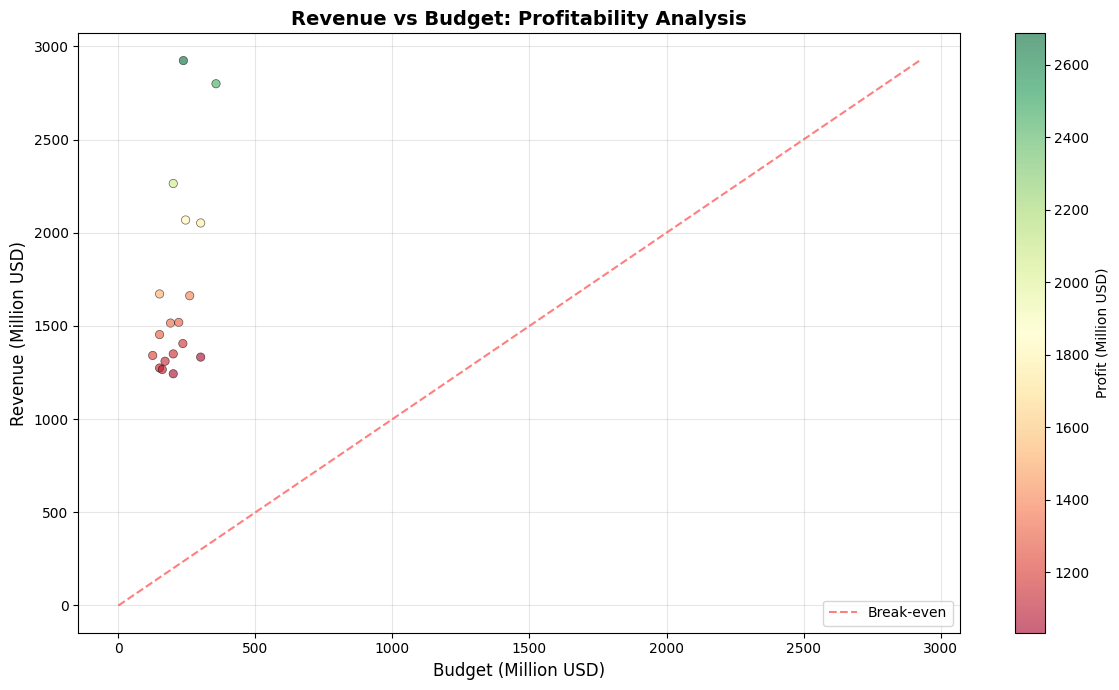

2025-12-15 14:58:38 - pipeline_notebook - INFO - ✓ Revenue vs Budget plot generated


In [39]:
logger.info("="*60)
logger.info("VISUALIZATION 1: REVENUE VS BUDGET")
logger.info("="*60)

fig, ax = plt.subplots(figsize=(12, 7))
plot_revenue_vs_budget(df, ax=ax)
plt.tight_layout()
plt.show()

logger.info("✓ Revenue vs Budget plot generated")

#### Insights from Revenue vs Budget scatter plot:
All analyzed movies were profitable, as every data point lies above the break-even line (Revenue > Budget)

## 2. ROI Distribution by Genre

Box plot showing Return on Investment (ROI) distribution across different genres. Only includes movies with budgets ≥ $10M to avoid low-budget outliers. Genres are sorted by median ROI.

2025-12-15 14:58:38 - pipeline_notebook - INFO - 
2025-12-15 14:58:38 - pipeline_notebook - INFO - ============================================================
2025-12-15 14:58:38 - pipeline_notebook - INFO - VISUALIZATION 2: ROI BY GENRE
2025-12-15 14:58:38 - pipeline_notebook - INFO - ============================================================


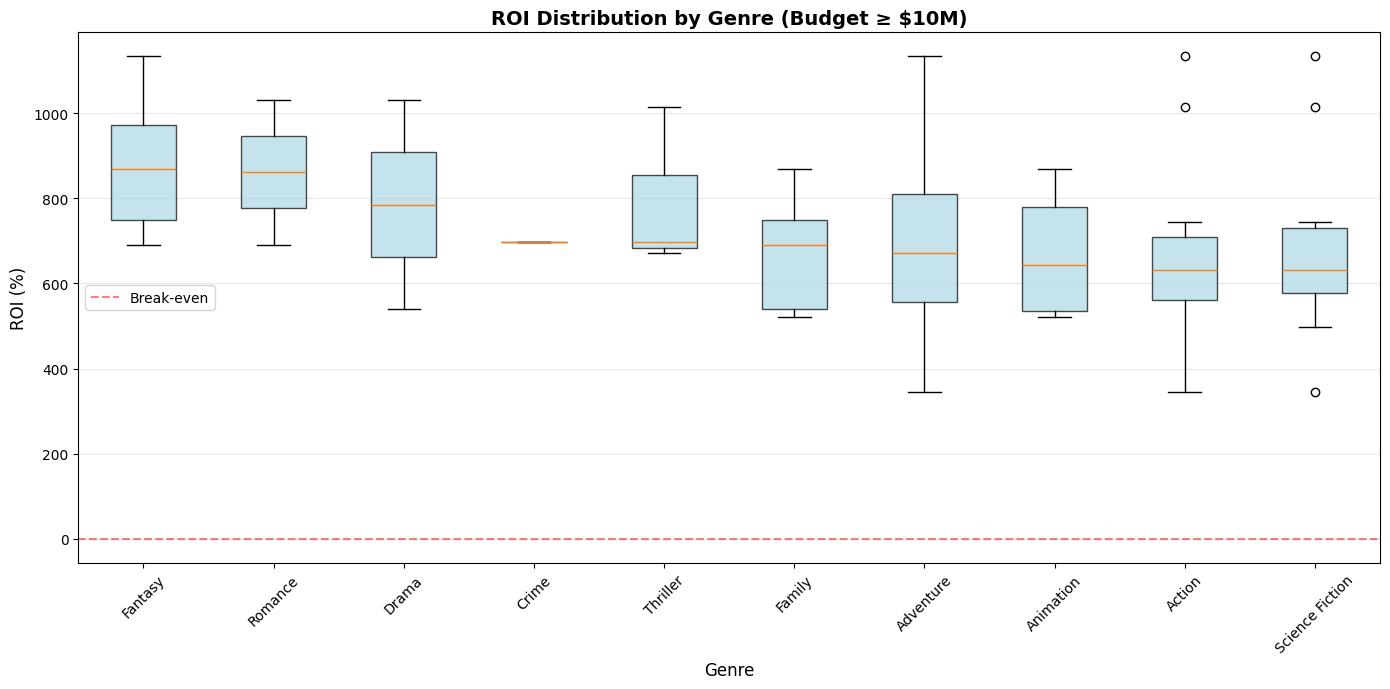

2025-12-15 14:58:38 - pipeline_notebook - INFO - ✓ ROI by Genre plot generated


In [40]:
logger.info("")
logger.info("="*60)
logger.info("VISUALIZATION 2: ROI BY GENRE")
logger.info("="*60)

fig, ax = plt.subplots(figsize=(14, 7))
plot_roi_by_genre(df, ax=ax, top_n=10)
plt.tight_layout()
plt.show()

logger.info("✓ ROI by Genre plot generated")

#### Insights from ROI by Genre box plot:

**Universal Profitability**: Every genre analyzed is highly profitable, with even the lowest-performing movies returning over 300% ROI.

**Best Average Returns**: Romance and Fantasy are the top performers, offering the highest median Return on Investment (approx. 850–900%).

**Most Predictable**: Crime has the most consistent performance (narrowest range), making it the "safest" bet.

**Highest Potential**: While Action and Adventure have lower medians, they show significant outliers (circles at the top), indicating the highest potential for massive, extreme profits

## 3. Popularity vs Rating

Scatter plot exploring the relationship between movie ratings and popularity scores. Point size represents vote count (larger = more votes). Includes a trend line showing the correlation.

2025-12-15 14:58:38 - pipeline_notebook - INFO - 
2025-12-15 14:58:38 - pipeline_notebook - INFO - ============================================================
2025-12-15 14:58:38 - pipeline_notebook - INFO - VISUALIZATION 3: POPULARITY VS RATING
2025-12-15 14:58:38 - pipeline_notebook - INFO - ============================================================


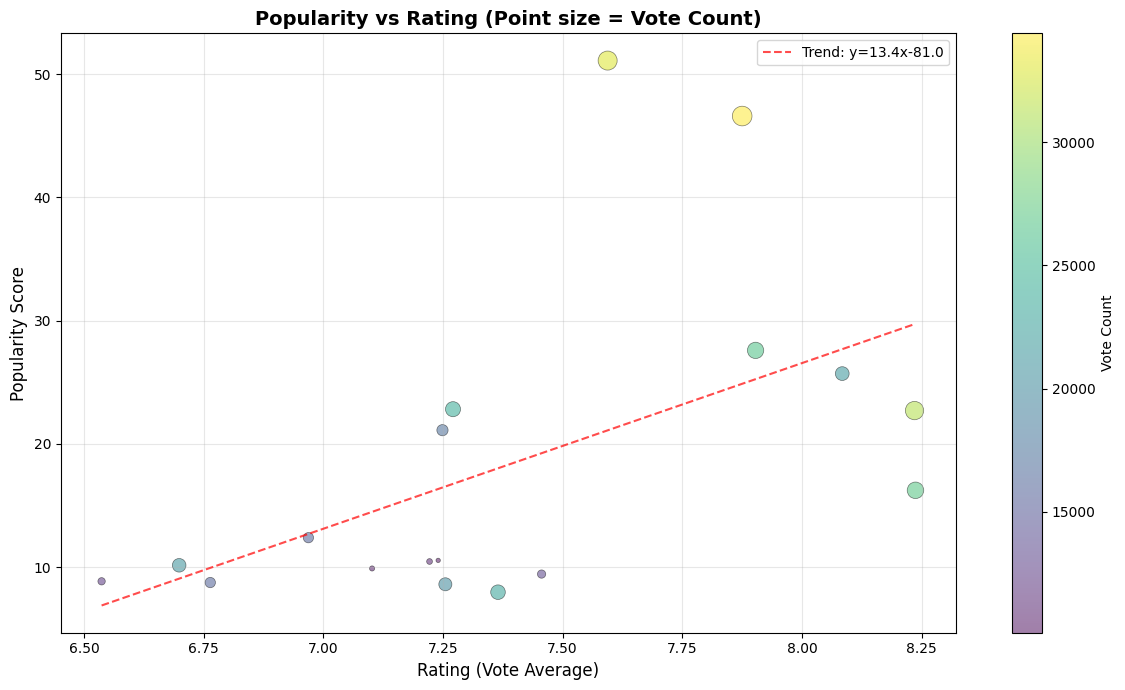

2025-12-15 14:58:38 - pipeline_notebook - INFO - ✓ Popularity vs Rating plot generated


In [41]:
logger.info("")
logger.info("="*60)
logger.info("VISUALIZATION 3: POPULARITY VS RATING")
logger.info("="*60)

fig, ax = plt.subplots(figsize=(12, 7))
plot_popularity_vs_rating(df, ax=ax)
plt.tight_layout()
plt.show()

logger.info("✓ Popularity vs Rating plot generated")

#### Insights from Popularity vs Rating scatter plot:

**Positive Trend:** There is a clear correlation where higher user ratings generally lead to higher popularity scores, as shown by the upward-sloping trend line.

**Engagement Drives Visibility:** The most popular movies (large yellow bubbles at the top) also have the highest vote counts, confirming that mass audience participation is the primary driver of high popularity scores.

**The "Blockbuster" Sweet Spot:** Peak popularity is achieved in the 7.5–8.0 rating range rather than at the extreme high end (>8.2), suggesting mainstream hits balance quality with broad appeal rather than perfection.

**Quality Doesn't Guarantee Hype:** Movies with the absolute highest ratings (>8.2) often display only moderate popularity (under 25), typical of "critically acclaimed" films that lack viral mainstream reach.


## 4. Yearly Trends in Box Office Performance

Line plot showing total box office revenue by release year (primary axis) and the number of movies released (secondary axis). Reveals trends in industry growth and output over time.

2025-12-15 14:58:38 - pipeline_notebook - INFO - 
2025-12-15 14:58:38 - pipeline_notebook - INFO - ============================================================
2025-12-15 14:58:38 - pipeline_notebook - INFO - VISUALIZATION 4: YEARLY BOX OFFICE TRENDS
2025-12-15 14:58:38 - pipeline_notebook - INFO - ============================================================


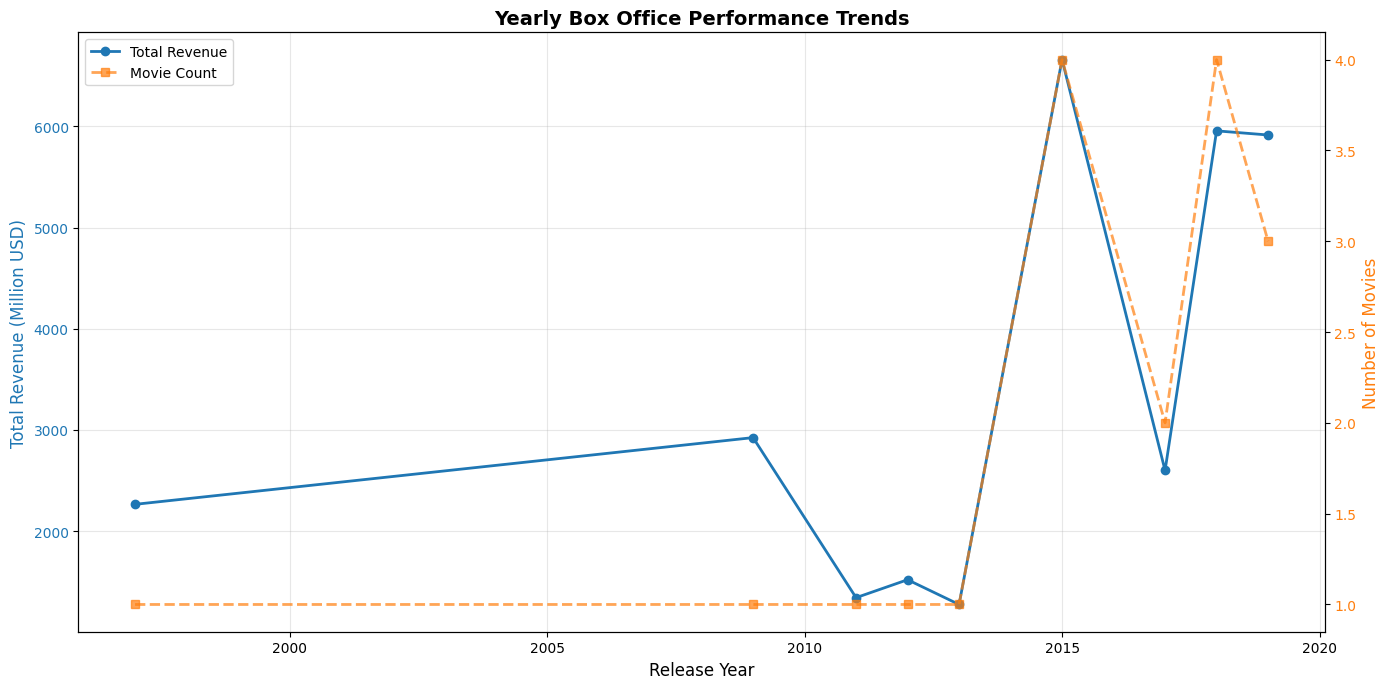

2025-12-15 14:58:38 - pipeline_notebook - INFO - ✓ Yearly Trends plot generated


In [42]:
logger.info("")
logger.info("="*60)
logger.info("VISUALIZATION 4: YEARLY BOX OFFICE TRENDS")
logger.info("="*60)

fig, ax = plt.subplots(figsize=(14, 7))
plot_yearly_trends(df, ax=ax)
plt.tight_layout()
plt.show()

logger.info("✓ Yearly Trends plot generated")

#### Insights from Yearly Box Office Performance Trends line chart:

**Volume is King:** Total revenue is heavily dependent on the quantity of releases; the historical peaks (2015 and 2018) align perfectly with the years having the highest number of movies (4 releases).

**Recent Surge in Output:** There is a distinct shift in activity starting in 2015, breaking the long trend of single-release years (1997–2013) and moving toward a strategy of multiple annual releases.

**High Volatility:** Revenue trends are unstable and see-saw dramatically - for instance, revenue crashed by over 60% in 2017 simply because the movie count dropped from 4 to 2.

**Lockstep Correlation:** The blue (revenue) and orange (count) lines track each other almost identically, confirming that aggregate growth in this dataset is driven primarily by scaling up production volume rather than just individual movie performance.


## 5. Franchise vs Standalone Success Comparison

Grouped bar chart comparing franchise movies to standalone movies across three metrics:
- Movie count
- Average revenue
- Average rating

Shows whether franchise films outperform standalone releases.

2025-12-15 14:58:38 - pipeline_notebook - INFO - 
2025-12-15 14:58:38 - pipeline_notebook - INFO - ============================================================
2025-12-15 14:58:38 - pipeline_notebook - INFO - VISUALIZATION 5: FRANCHISE VS STANDALONE
2025-12-15 14:58:38 - pipeline_notebook - INFO - ============================================================


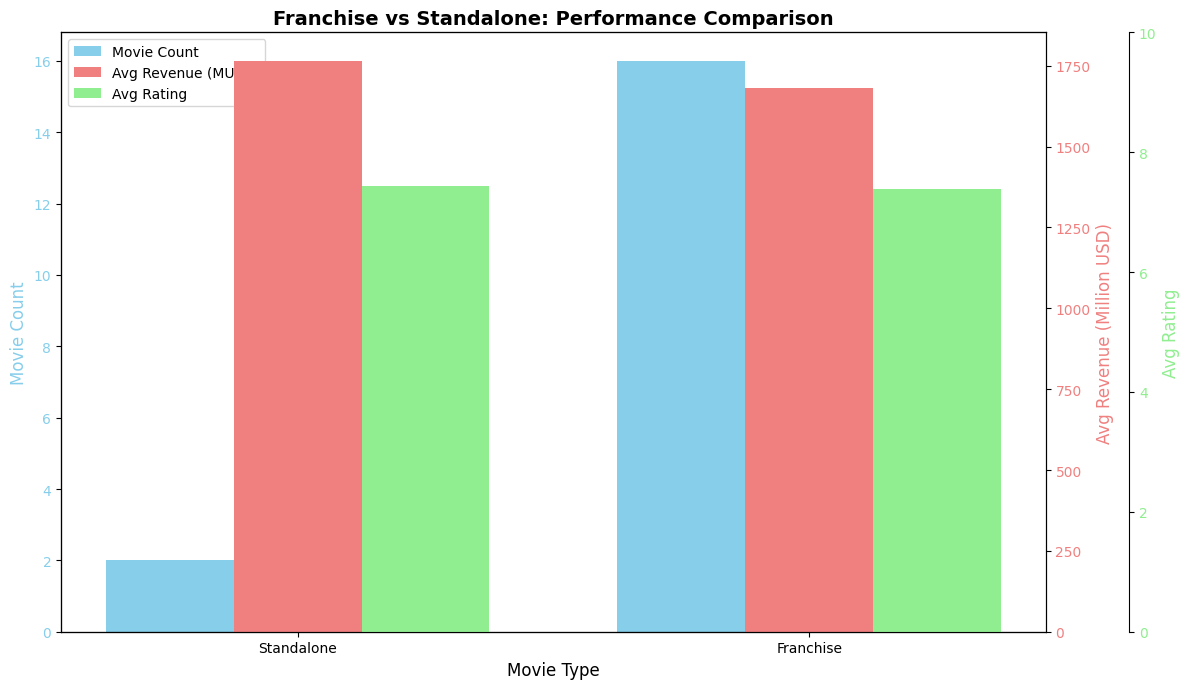

2025-12-15 14:58:38 - pipeline_notebook - INFO - ✓ Franchise Comparison plot generated


In [43]:
logger.info("")
logger.info("="*60)
logger.info("VISUALIZATION 5: FRANCHISE VS STANDALONE")
logger.info("="*60)

fig, ax = plt.subplots(figsize=(12, 7))
plot_franchise_comparison(df, ax=ax)
plt.tight_layout()
plt.show()

logger.info("✓ Franchise Comparison plot generated")

#### Insights from Franchise vs Standalone bar chart:

**Quantity Disparity:** The dataset is overwhelmingly dominated by Franchises (16 movies) compared to just 2 Standalone films

**Standalone Excellence:** Despite their small numbers, Standalone movies slightly outperform Franchises in both average revenue (peaking above $1,750M) and average rating, indicating these specific films were exceptional "lightning in a bottle" hits.

**High Floor for Franchises:** Even with a much higher volume of releases, Franchises maintain a massive average revenue (~$1,700M) and strong ratings (~7.4), proving the consistency and reliability of the franchise model.
